In [18]:
import torch
from diffusers import StableDiffusionPipeline
import clip
from PIL import Image
import numpy as np
import cv2  # OpenCV for image processing
import sam  # Assuming you have installed SAM2 correctly
import matplotlib.pyplot as plt
import base64


In [19]:
def image_to_base64(image):
    from io import BytesIO
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

In [20]:
# Set up Stable Diffusion
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")

# Generate an image based on the prompt
prompt = "a mom holding a baby"
image = pipe(prompt).images[0]
image.save("generated_image.png")  # Save the image for analysis
image.show()  # Show the generated image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [21]:
# Set up CLIP
model, preprocess = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")

# Preprocess the generated image for CLIP
image_clip = preprocess(image).unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")

# Define possible text descriptions for analysis
text_prompts = ["landscape", "mountains", "sunset", "river", "sky"]
text_inputs = clip.tokenize(text_prompts).to("cuda" if torch.cuda.is_available() else "cpu")

# Analyze the image using CLIP
with torch.no_grad():
    image_features = model.encode_image(image_clip)
    text_features = model.encode_text(text_inputs)

    # Calculate similarity scores
    logits_per_image, logits_per_text = image_features @ text_features.T, text_features @ image_features.T
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()
# Collect CLIP results into a dictionary
clip_results = {text: float(probs[0][i]) for i, text in enumerate(text_prompts)}
# Print the results from CLIP
for i, text in enumerate(text_prompts):
    print(f"Prompt: '{text}', Confidence Score: {probs[0][i]:.4f}")

Prompt: 'landscape', Confidence Score: 0.1394
Prompt: 'mountains', Confidence Score: 0.1671
Prompt: 'sunset', Confidence Score: 0.0038
Prompt: 'river', Confidence Score: 0.6696
Prompt: 'sky', Confidence Score: 0.0201


Using device: cpu


c:\anaconda\.conda\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


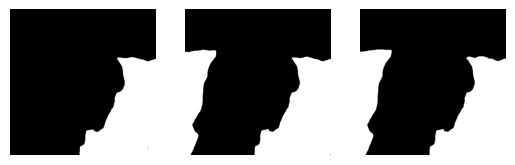

In [22]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import build_sam, SamPredictor
from segment_anything import SamPredictor, sam_model_registry
sam_checkpoint = "checkpoints/sam_vit_h_4b8939.pth"  # Path to your checkpoint file
# Check if you have a GPU and set the device accordingly
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load the SAM model with the appropriate checkpoint
sam_checkpoint = "sam_vit_h_4b8939.pth"  # Path to SAM model checkpoint
sam_model = sam_model_registry["vit_h"](checkpoint=sam_checkpoint).to(device)

# Initialize the SAM predictor
predictor = SamPredictor(sam_model)

# Load and preprocess the image
image_path = "generated_image.png"  # Path to the image you want to segment
sam_image = cv2.imread(image_path)
sam_image = cv2.cvtColor(sam_image, cv2.COLOR_BGR2RGB)

# Set the image in the predictor
predictor.set_image(sam_image)

# You can now interact with the SAM model to get masks (e.g., using points)
input_point = np.array([[500, 375]])  # Example point for instance segmentation
input_label = np.array([1])

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True  # Enable multi-mask output for different options
)

# Display the mask
for idx, mask in enumerate(masks):
    plt.subplot(1, len(masks), idx + 1)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

plt.show()


In [32]:
# Convert masks and scores to JSON-compatible format (lists)
masks_list = [mask.tolist() for mask in masks]
scores_list = scores.tolist()

In [31]:
data_to_save = {
    "generated_image": image_to_base64(image),  # Convert image to base64 string
    "clip_results": clip_results,  # CLIP analysis results (confidence scores)
    "sam_masks": masks_list,  # SAM2 segmentation masks as lists
    "sam_scores": scores_list  # SAM2 segmentation scores as lists
}


In [24]:
import pickle
with open('stble_clif_sam2.pickle', 'wb') as f:
    pickle.dump(data_to_save,f)

In [33]:
import json
# Save everything to a JSON file
with open('stble_clif_sam2.json', 'w') as f:
    json.dump(data_to_save, f, indent=4)